In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
import os
import pathlib
import itertools
import glob
import re
package_path = os.path.join(pathlib.Path.home(), "mkvchain")
sys.path.append(package_path)
from model import FeatureDependentMarkovChain

In [52]:
import sklearn

In [2]:
root = pathlib.Path.home()
# pt = os.path.join(root, 'research', 'gen_287_2013_2017_state.csv')
pt = os.path.join(root, 'research', 'GADS_Processed', "trajectories_with_features")

def glob_re(pattern, strings):
    return list(filter(re.compile(pattern).match, strings))

filenames = glob_re(r"gen_\d+_type_200_dtgrp_\d+_rating_\d+_state_Texas_raw.csv", os.listdir(pt))


In [3]:
states_new = []
features_new = []
lengths_new = []

for f in filenames:
    data = pd.read_csv(os.path.join(pt,f))
    data.set_index("x", inplace=True)
    data.rename(columns=dict(zip(data.columns, [str(i) for i in range(len(data.columns))])), inplace=True)
    data.dropna(inplace=True)

    states = data["1"].values.tolist()
    features = data[["2", "3", "4"]].values
    l = len(data)

    states_new += [states]
    features_new += [features]
    lengths_new += [l]

states = np.concatenate(states_new).astype(int)
states -= 1
features = np.vstack(features_new)
lengths = np.array(lengths_new)

In [59]:
data

,0,1,2,3,4
x,,,,,
2013-01-01T06:00:00.0,1.0,1.0,7305,10472.12636,1
2013-01-01T07:00:00.0,1.0,1.0,7305,10891.21790,1
2013-01-01T08:00:00.0,1.0,1.0,7305,11190.20403,1
2013-01-01T09:00:00.0,1.0,1.0,7305,11627.12738,1
2013-01-01T10:00:00.0,1.0,1.0,7305,12310.00187,1
...,...,...,...,...,...
2023-12-31T20:00:00.0,1.0,1.0,11322,12423.90000,365
2023-12-31T21:00:00.0,1.0,1.0,11322,12226.08000,365
2023-12-31T22:00:00.0,1.0,1.0,11322,12039.30000,365


In [5]:
states.shape

(385608,)

In [6]:
train_idx = 2 # int(lengths.size * .8)
val_idx = 3 #int(lengths.size * .9)

lengths_train = lengths[:train_idx]
lengths_val = lengths[train_idx:val_idx]
lengths_test = lengths[val_idx:]

states_train = states[:lengths_train.sum()]
states_val = states[lengths_train.sum():lengths_train.sum()+lengths_val.sum()]
states_test = states[lengths_train.sum()+lengths_val.sum():]

features_train = features[:lengths_train.sum()]
features_val = features[lengths_train.sum():lengths_train.sum()+lengths_val.sum()]
features_test = features[lengths_train.sum()+lengths_val.sum():]

In [7]:
len(features)

385608

In [8]:
features_train.shape, features_val.shape, features_test.shape

((192804, 3), (96402, 3), (96402, 3))

In [9]:
states_train.shape, states_val.shape, states_test.shape

((192804,), (96402,), (96402,))

In [10]:
from sklearn.preprocessing import QuantileTransformer, StandardScaler
ss = StandardScaler()

features_train = ss.fit_transform(features_train)
features_val = ss.transform(features_val)
features_test = ss.transform(features_test)

In [23]:
import matplotlib.colors as colors

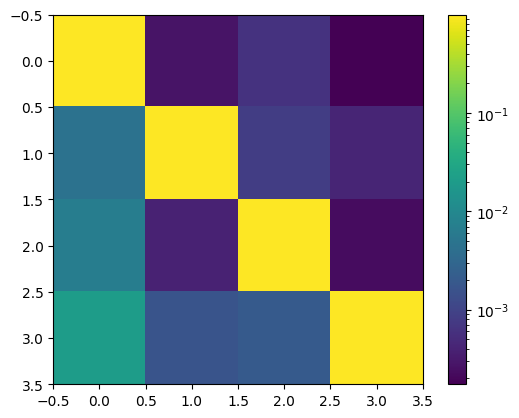

In [30]:
n = len(np.unique(states))
i = 0
P = np.zeros((n,n))
for l in lengths:
    for j in range(i, i+l-1):
        P[states[j], states[j+1]] += 1
    i += l
P = P / P.sum(axis=1)[:, None]
plt.imshow(P, norm=colors.LogNorm(vmin=np.min(P), vmax=np.max(P)))
plt.colorbar()

In [13]:
model1 = FeatureDependentMarkovChain(n, lam_frob=0, n_iter=1)
model1.fit(states_train, features_train*0, lengths_train, verbose=False)
train1, val1, test1 = model1.score(states_train, features_train*0, lengths_train, average=False), \
    model1.score(states_val, features_val*0, lengths_val, average=False), \
    model1.score(states_test, features_test*0, lengths_test, average=False)
train1, val1, test1

(np.float64(-1536.4679172060019),
 np.float64(-2613.6603291658057),
 np.float64(-2169.407581466809))

In [ ]:
predictions = model1.predict(features_test)

In [50]:
for i, j in itertools.product(range(4), range(4)):
    y = predictions[:, i, j]
    val = np.unique(y)
    print(f"{i} -> {j} : {val}")

0 -> 0 : [0.99942763]
0 -> 1 : [0.00018504]
0 -> 2 : [0.00038157]
0 -> 3 : [5.77048227e-06]
1 -> 0 : [0.00673201]
1 -> 1 : [0.99305002]
1 -> 2 : [0.00021796]
1 -> 3 : [1.68218657e-08]
2 -> 0 : [0.0044361]
2 -> 1 : [4.92633674e-10]
2 -> 2 : [0.9955639]
2 -> 3 : [4.92633674e-10]
3 -> 0 : [0.0093329]
3 -> 1 : [1.18773837e-06]
3 -> 2 : [1.18773837e-06]
3 -> 3 : [0.99066473]


In [54]:
sklearn.feature_selection.f_classif(features, states)

(array([6180.61408909, 2143.2206524 ,  815.0338365 ]), array([0., 0., 0.]))

In [55]:
sklearn.feature_selection.mutual_info_regression(features, states)

array([0.26596283, 0.00707873, 0.07898   ])

In [58]:
features

array([[8.76600000e+03, 7.05073078e+03, 1.00000000e+00],
       [8.76600000e+03, 7.17778719e+03, 1.00000000e+00],
       [8.76600000e+03, 7.22321256e+03, 1.00000000e+00],
       ...,
       [1.13220000e+04, 1.20393000e+04, 3.65000000e+02],
       [1.13220000e+04, 1.18447900e+04, 3.65000000e+02],
       [1.13220000e+04, 1.18298400e+04, 1.00000000e+00]],
      shape=(385608, 3))

/tmp/ipykernel_742231/1828117095.py:4: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(np.min(predictions[:, 1, 1]), np.max(predictions[:, 1, 1]))


(0.9433975163363789, 1.0427025180559977)

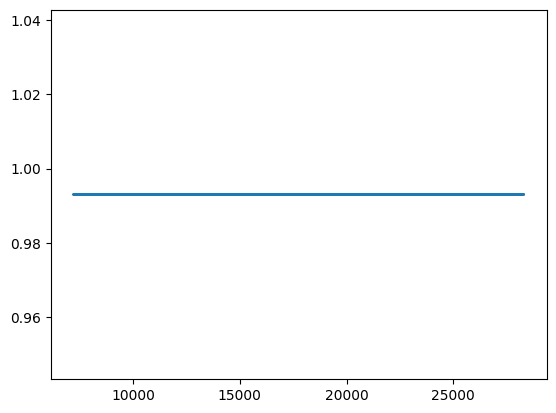

In [ ]:
fig, ax = plt.subplots()

y = predictions[:, 1, 1]

ax.plot(features[lengths_train.sum()+lengths_val.sum():][:, 1], y)

In [ ]:
fig, ax = plt.subplots()

ax.scatter()

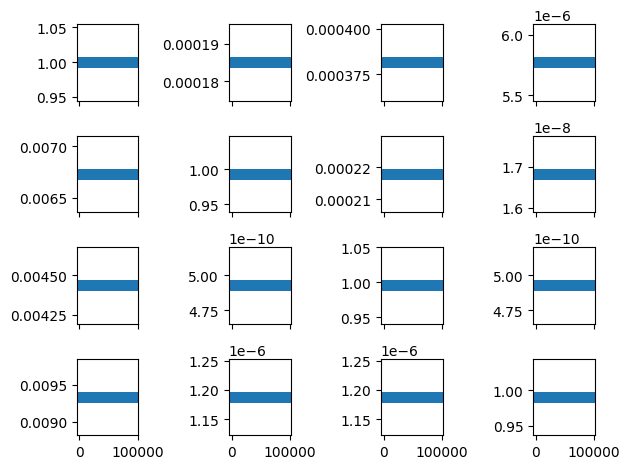

In [15]:
fig, ax = plt.subplots(nrows=4, ncols=4, sharex=True)
for i, j in itertools.product(range(4), range(4)):
    ax[i, j].scatter(range(len(predictions)), predictions[:, i, j])

fig.tight_layout()

In [115]:
len(features_test)

96407

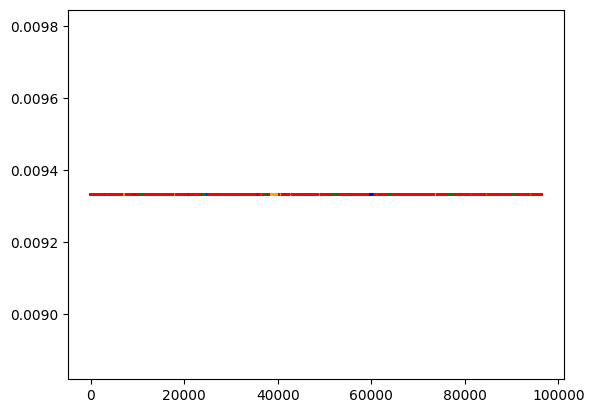

In [20]:
fig, ax = plt.subplots()

cmap = {0:'red', 1: 'orange', 2: "green", 3: "blue"}

colors = [cmap[v] for v in states_test]
ax.scatter(range(len(predictions)), predictions[:, 3, 0], c=colors, s=1)

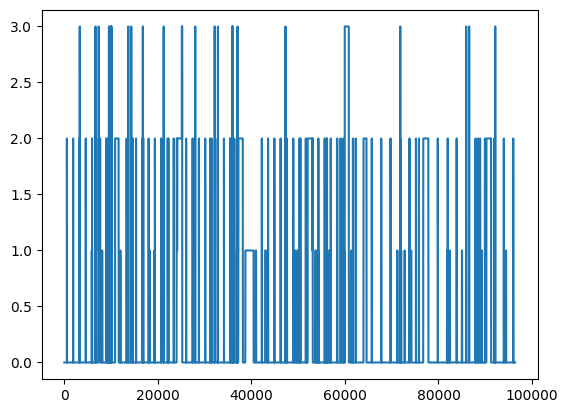

In [101]:
fig, ax = plt.subplots()
ax.plot(range(96403), states_test)

In [100]:
states_test

array([0, 0, 0, ..., 0, 0, 0], shape=(96403,))